# RNN APPROACH

In [3]:
import data_loader
import numpy as np
import keras
from keras import backend as K
from keras.models import Model,Sequential,load_model
from keras.layers import Dense,GRU,LSTM,Input,Lambda,Activation,Embedding,Merge,merge,RepeatVector
from keras.layers.wrappers import TimeDistributed
import seaborn as sns
import matplotlib.pyplot as plt
import cPickle as pkl

Using Theano backend.


In [4]:
def rnn_generator_for_evaluation(split,batch_size,n_epochs=1,test=False,partition=0):
    dl = data_loader.DataLoader(split,test=test)
    for ecal,target in dl.batch_iter(partition,batch_size,n_epochs):
        flat = np.array([[x[:,:,i].flatten() for i in range(x.shape[-1])] for x in ecal])
        X = flat[:,:-1,:]
        Y = flat[:,1:,:]
        P = np.zeros((Y.shape[0],2))
        P[np.arange(P.shape[0]),np.array([int(t[0]) for t in target])] = 1
        M = np.array([t[1] for t in target])
        X_dict = {'X_input': X,
                  'P_input': P,
                  'M_input': M}
        Y_dict = {'output': Y}
        yield (X_dict,Y_dict,np.array([t for t in target]),np.array([x for x in ecal]))

In [7]:
many = rnn_generator_for_evaluation([90,10],4,n_epochs=1,test=True,partition=0)
for m in many:
    print m[0]['X_input'].shape, m[1]['output'].shape

 [DATA] Partition 0: Epoch 1 of 1
(4, 24, 400) (4, 24, 400)
(4, 24, 400) (4, 24, 400)
(2, 24, 400) (2, 24, 400)
(4, 24, 400) (4, 24, 400)
(2, 24, 400) (2, 24, 400)
(4, 24, 400) (4, 24, 400)
(4, 24, 400) (4, 24, 400)
(4, 24, 400) (4, 24, 400)
(2, 24, 400) (2, 24, 400)
(4, 24, 400) (4, 24, 400)
(2, 24, 400) (2, 24, 400)
(4, 24, 400) (4, 24, 400)
(2, 24, 400) (2, 24, 400)
(4, 24, 400) (4, 24, 400)
(4, 24, 400) (4, 24, 400)
(4, 24, 400) (4, 24, 400)
(2, 24, 400) (2, 24, 400)
(4, 24, 400) (4, 24, 400)
(4, 24, 400) (4, 24, 400)
(4, 24, 400) (4, 24, 400)
(2, 24, 400) (2, 24, 400)
(2, 24, 400) (2, 24, 400)
(4, 24, 400) (4, 24, 400)
(4, 24, 400) (4, 24, 400)
(4, 24, 400) (4, 24, 400)
(2, 24, 400) (2, 24, 400)
(4, 24, 400) (4, 24, 400)


In [8]:
saved_model = '/Users/malkini/udonarc/rnntest_model'
model = load_model(saved_model)

/Users/malkini/anaconda2/lib/python2.7/site-packages/keras/legacy/layers.py:66: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  warnings.warn('The `Merge` layer is deprecated '


In [52]:
def generate_rnn(model,input_dict,output,start):
    current = input_dict['X_input'].copy()
    for index in range(start,24):
        new = model.predict(input_dict)
        current[:,index-1,:] = new[:,index,:].copy()
        input_dict['X_input'] = current.copy()
    return new

In [53]:
many = rnn_generator_for_evaluation([90,10],4,n_epochs=1,test=True,partition=0)

true = []      # actual data
pred = []      # predicted
gen = []       # generated data
meta = []      # particle-type, momentum

i=0 
for m in many:
    print i
    meta.append(m[2])
    true.append(m[3])
    pred.append(model.predict(m[0]))
    gen.append(generate_rnn(model,m[0],m[3],5))
    i += 1
true = np.concatenate(true,axis=0)
pred = np.concatenate(pred,axis=0)
gen = np.concatenate(gen,axis=0)
meta = np.concatenate(meta,axis=0)

[DATA] Partition 0: Epoch 1 of 1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


In [54]:
print true.shape, pred.shape, gen.shape, meta.shape

(90, 20, 20, 25) (90, 24, 400) (90, 24, 400) (90, 2)


In [55]:
pp = []
gg = []
for i in range(pred.shape[0]):
  pp.append(np.concatenate([np.reshape(pred[i,j,:],(1,20,20)) for j in range(pred.shape[1])],axis=0))
  gg.append(np.concatenate([np.reshape(gen[i,j,:],(1,20,20)) for j in range(gen.shape[1])],axis=0))

pp = np.swapaxes(pp,1,3)
gg = np.swapaxes(gg,1,3)
pad = np.zeros((pp.shape[0],pp.shape[1],pp.shape[2],1))
pred_full = np.concatenate([pad,pp],axis=3)
gen_full = np.concatenate([pad,gg],axis=3)

In [56]:
print pred_full.shape
print gen_full.shape
print true.shape
print meta.shape

(90, 20, 20, 25)
(90, 20, 20, 25)
(90, 20, 20, 25)
(90, 2)


In [57]:
pkl.dump((true,meta),open('./rnn_true.pkl','wb'))
pkl.dump((pred_full,meta),open('./rnn_pred.pkl','wb'))
pkl.dump((gen_full,meta),open('./rnn_gen.pkl','wb'))

In [62]:
print gen_full.shape, pred_full.shape
print (gen_full[:,:,:,:6]==pred_full[:,:,:,:6]).sum(),gen_full[:,:,:,:6].size
print gen_full[0,10:15,10:15,3]
print pred_full[0,10:15,10:15,3]

(90, 20, 20, 25) (90, 20, 20, 25)
212771 216000
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]


0
----------------------


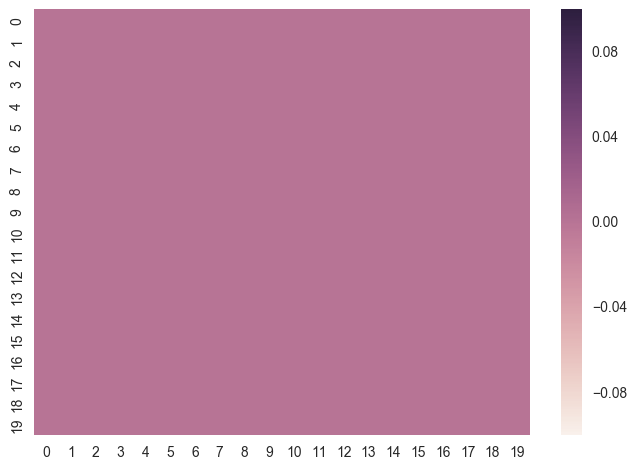

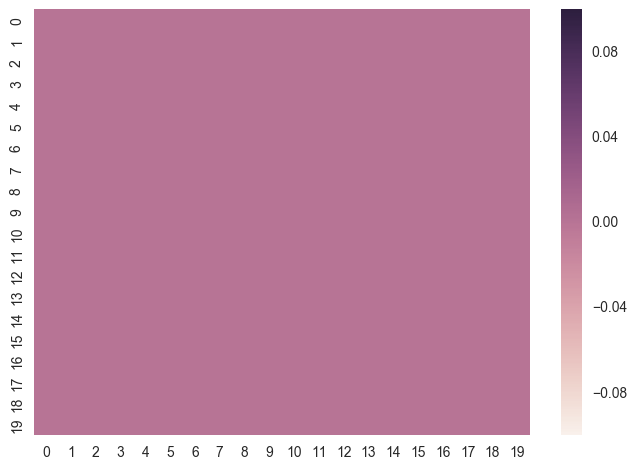

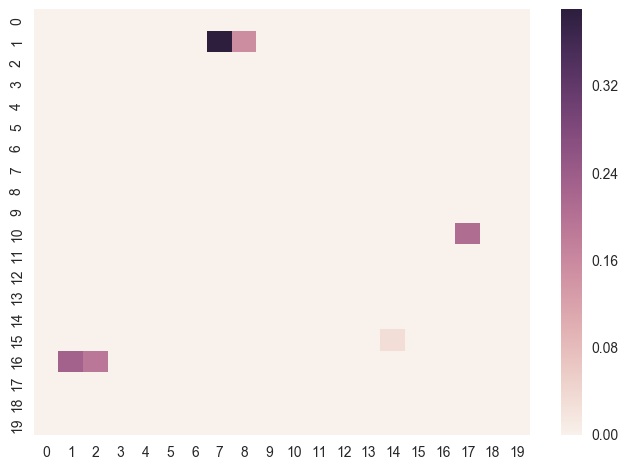

1
----------------------


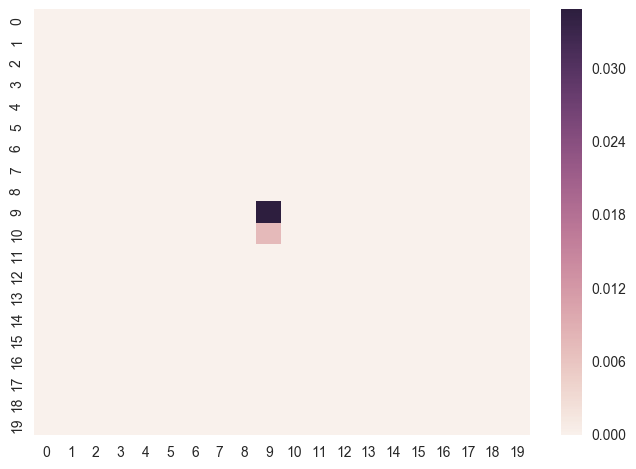

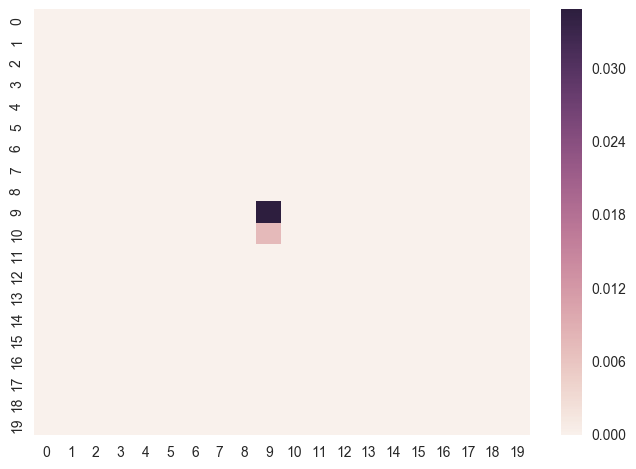

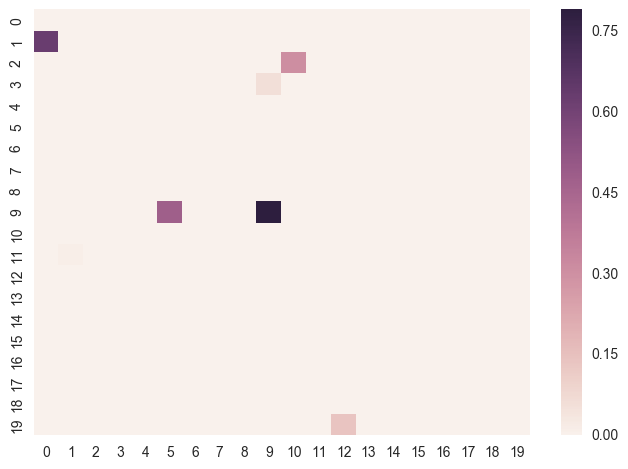

2
----------------------


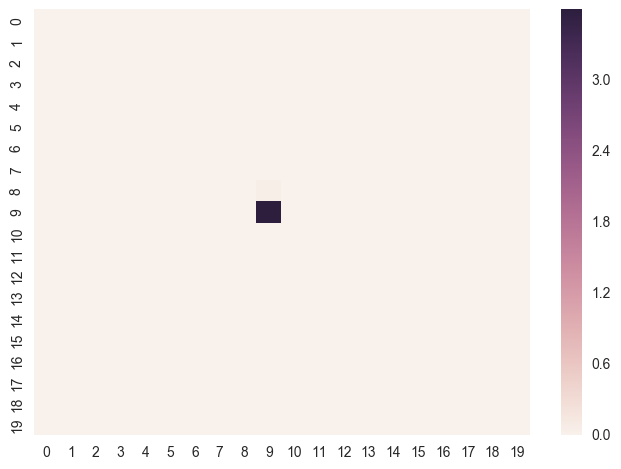

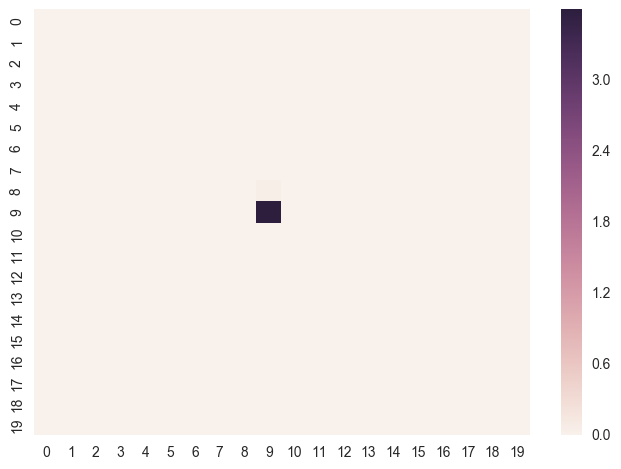

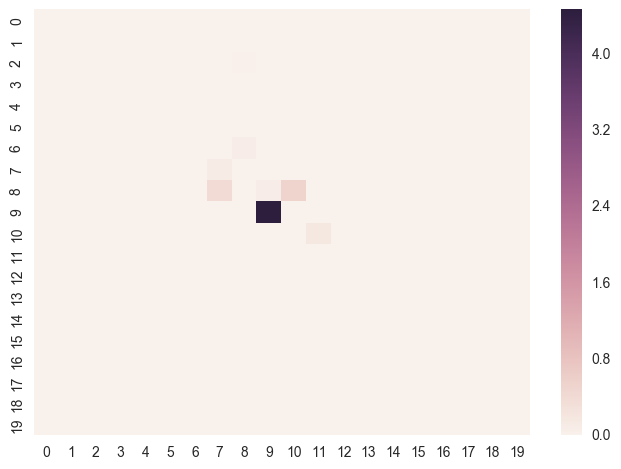

3
----------------------


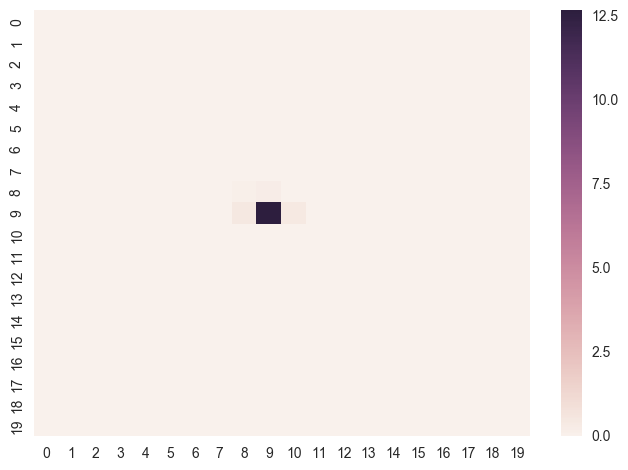

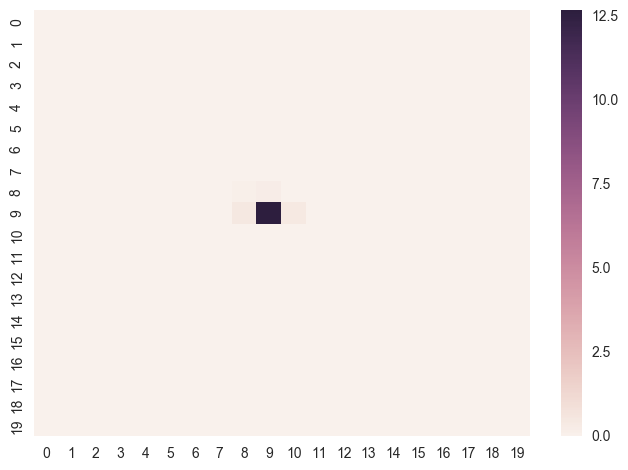

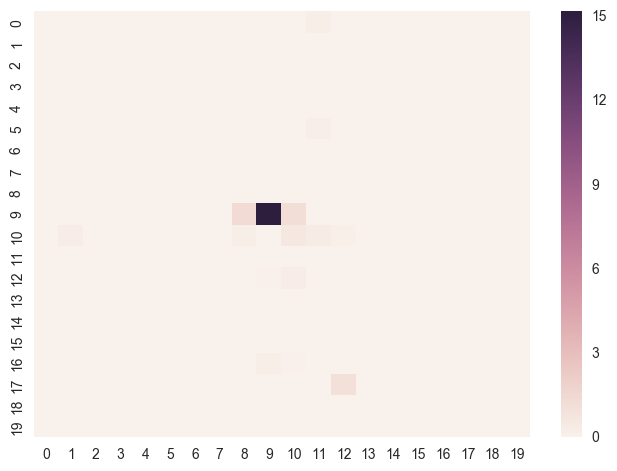

4
----------------------


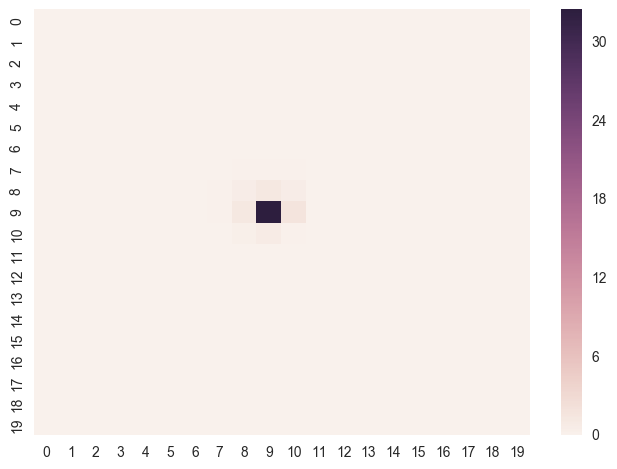

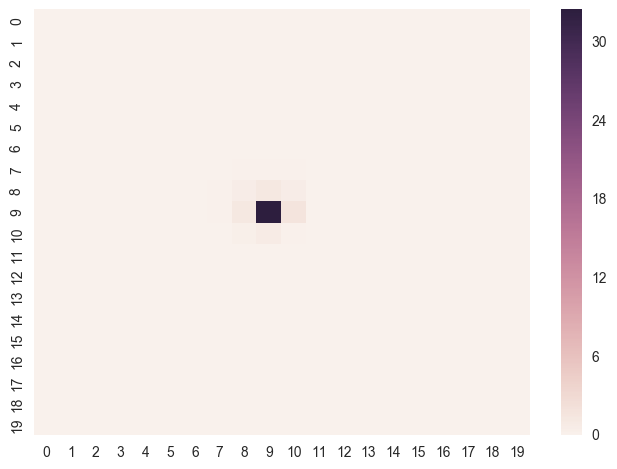

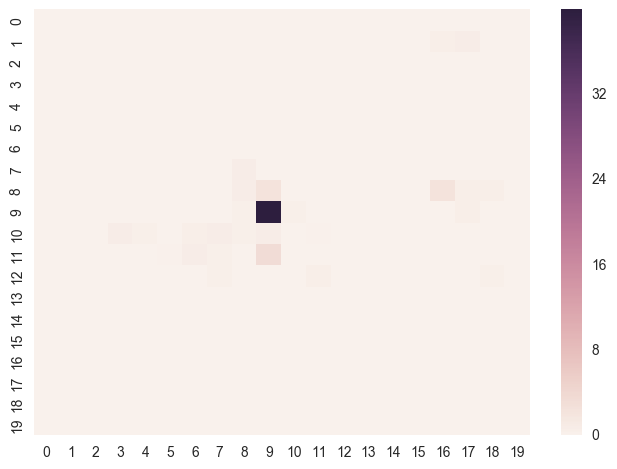

5
----------------------


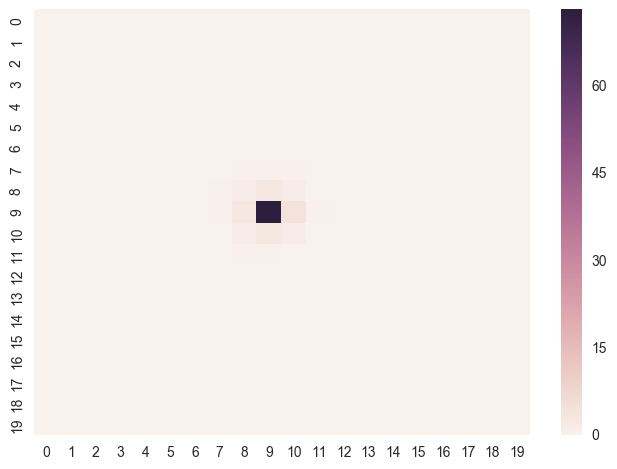

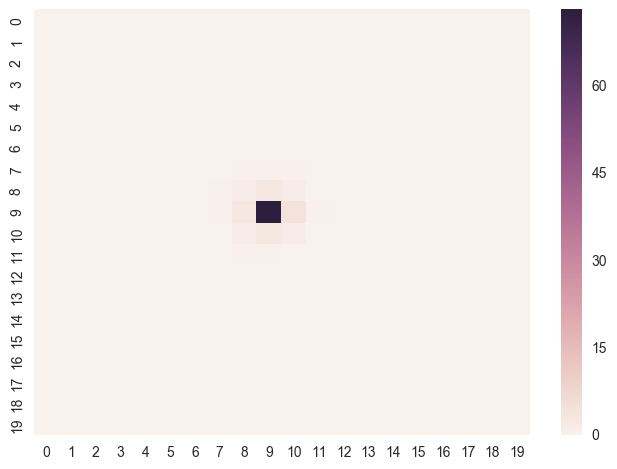

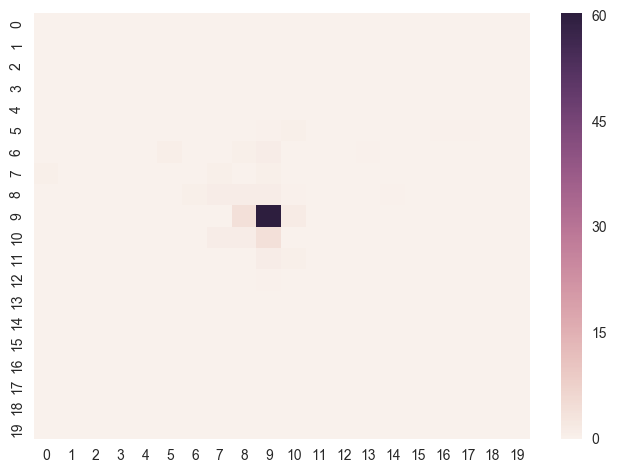

6
----------------------


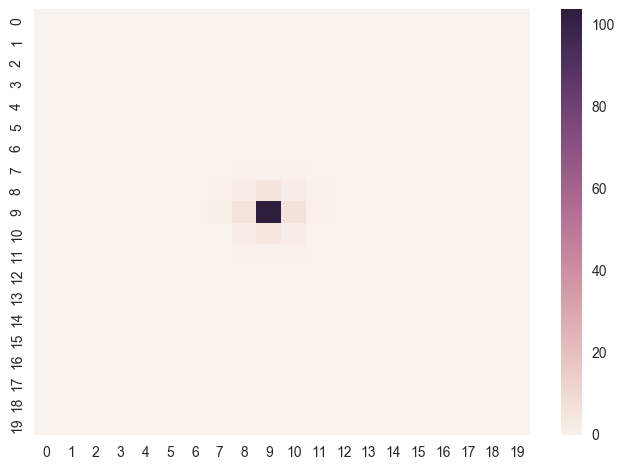

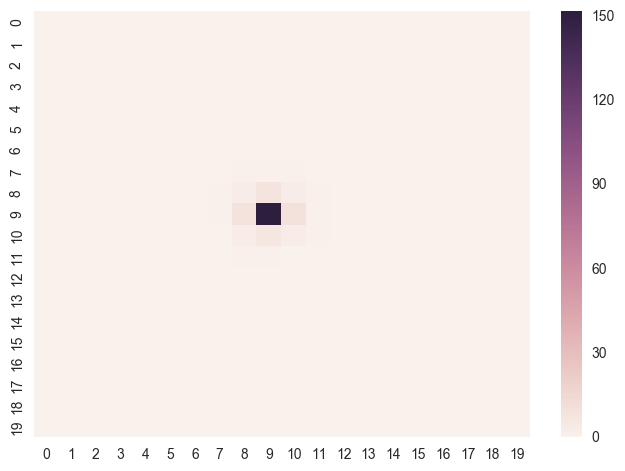

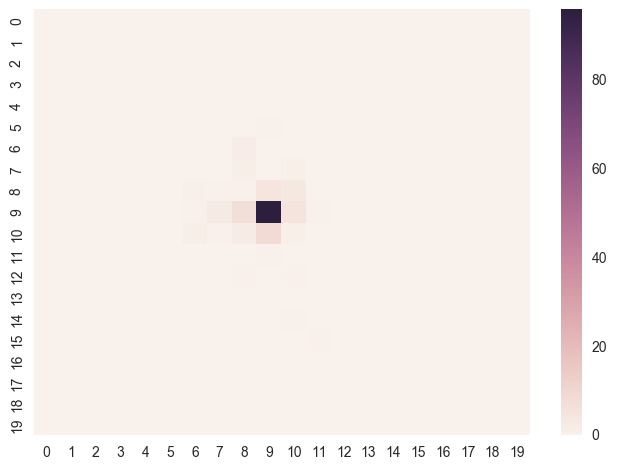

7
----------------------


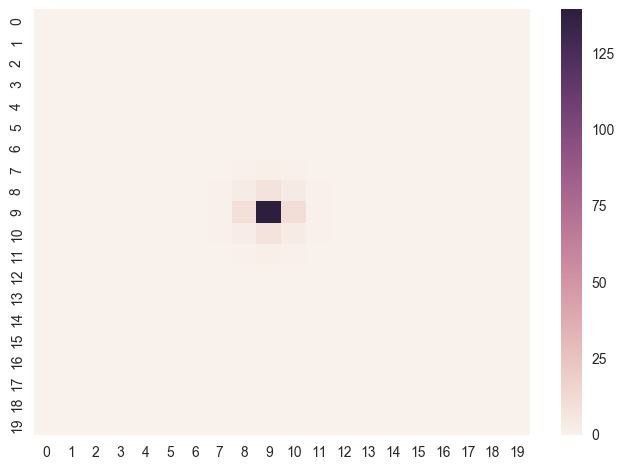

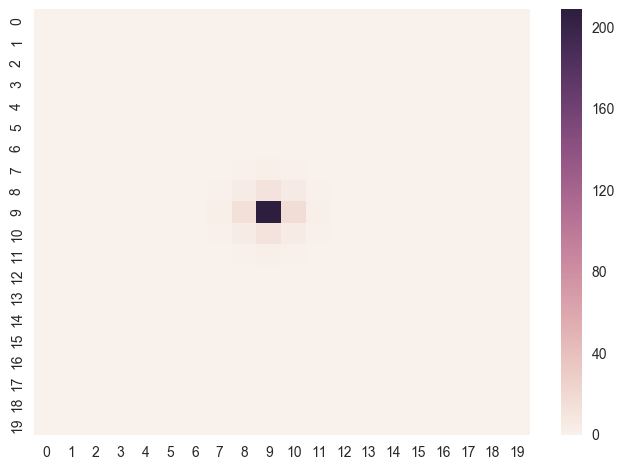

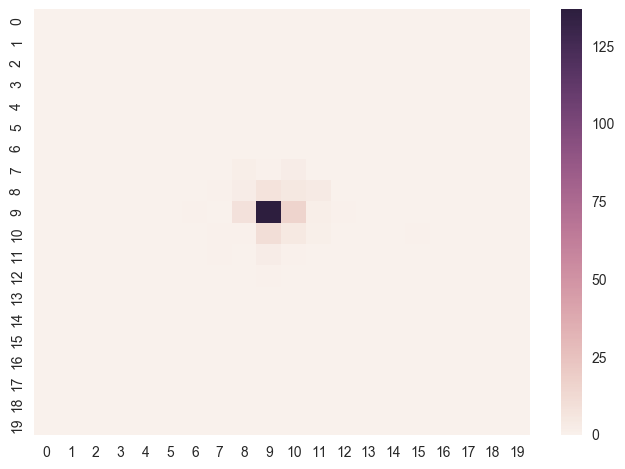

8
----------------------


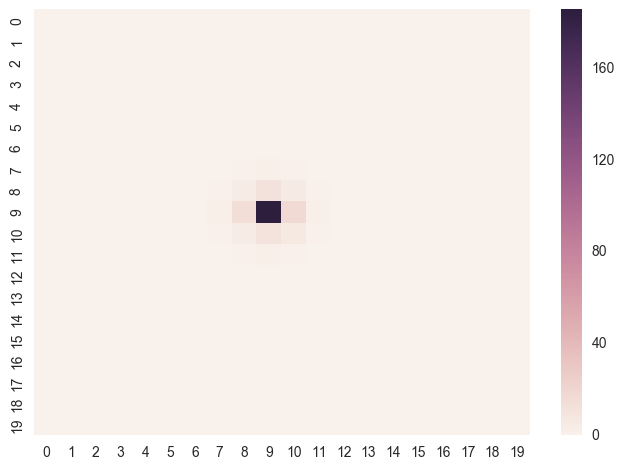

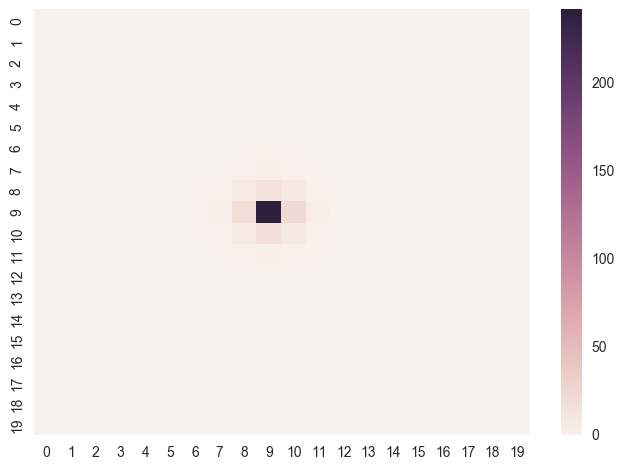

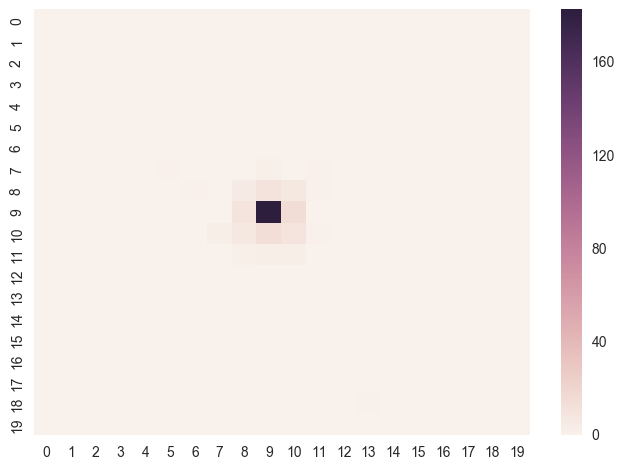

9
----------------------


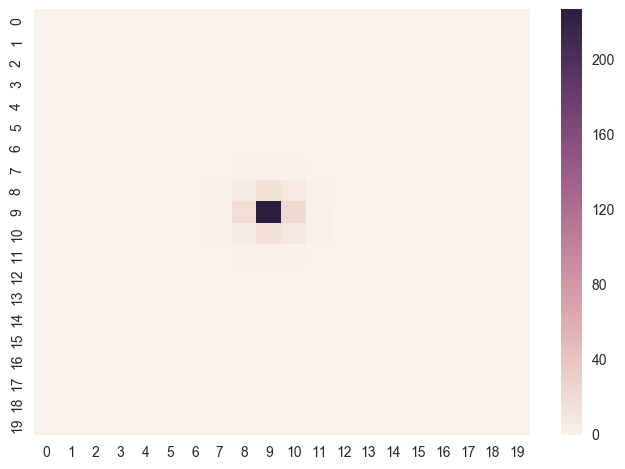

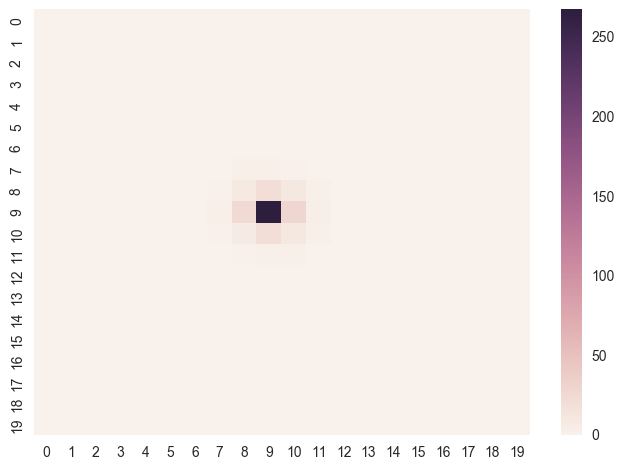

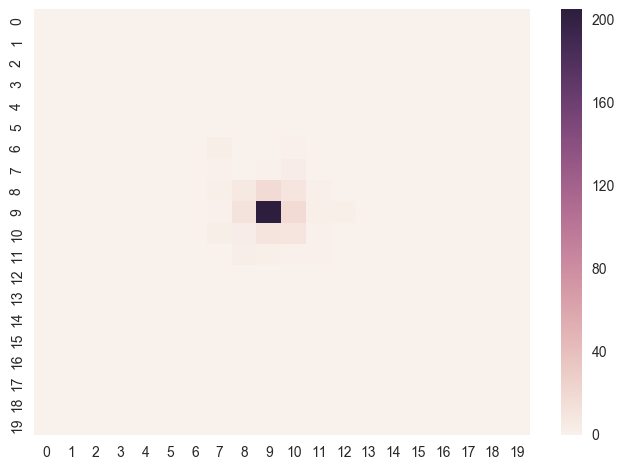

10
----------------------


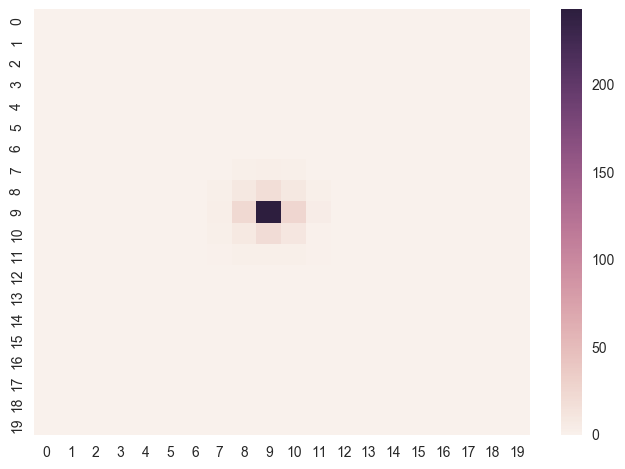

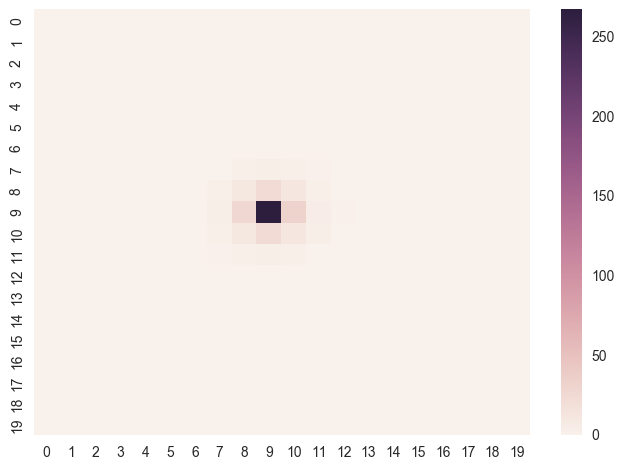

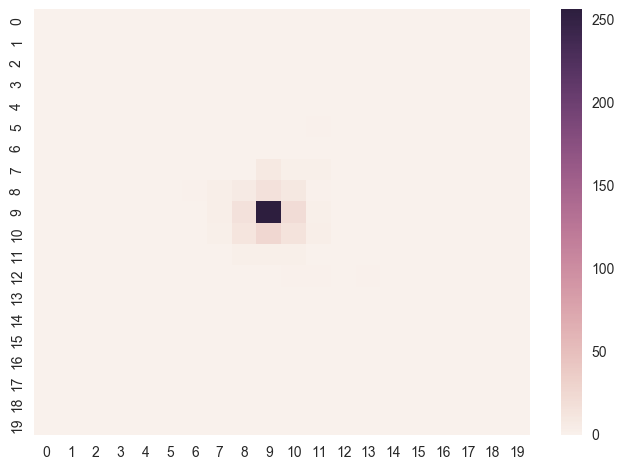

11
----------------------


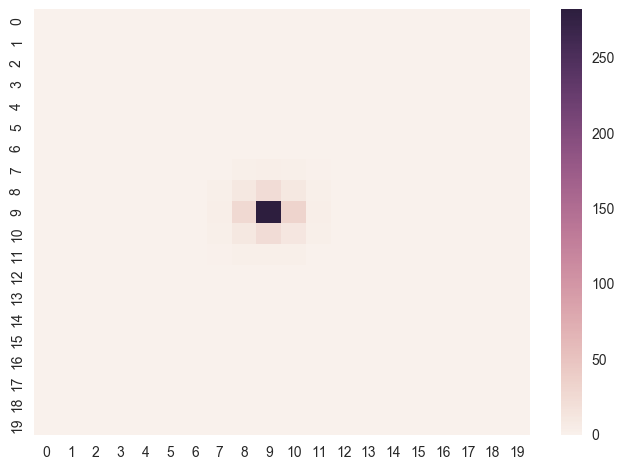

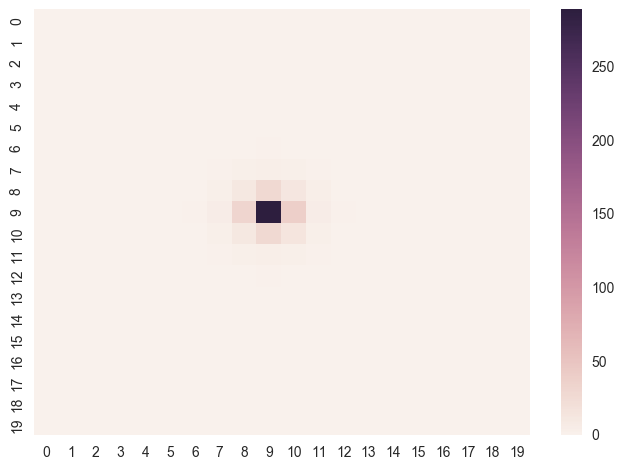

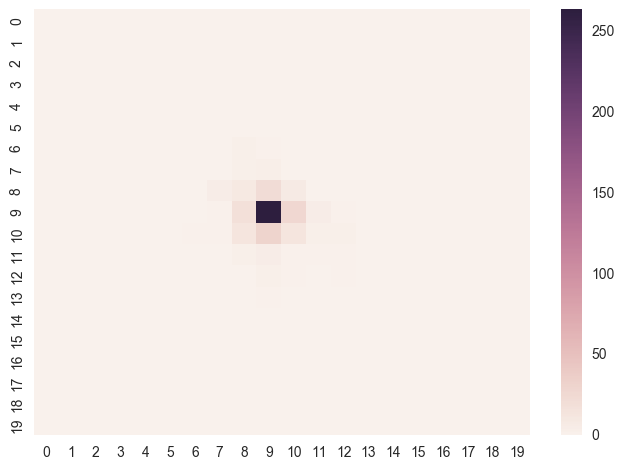

12
----------------------


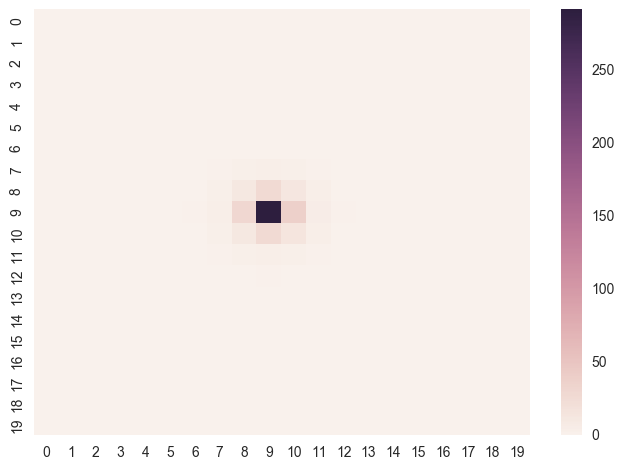

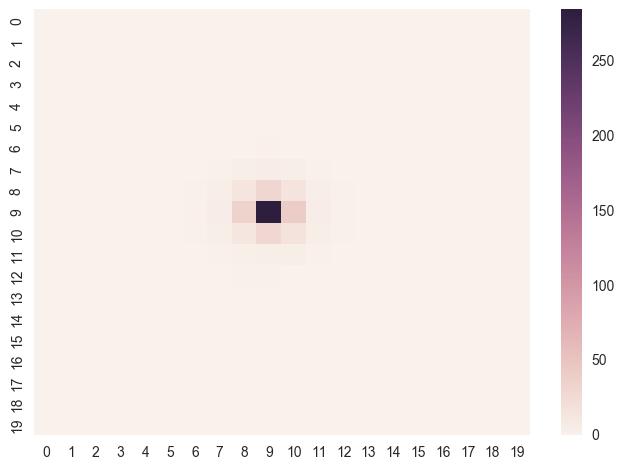

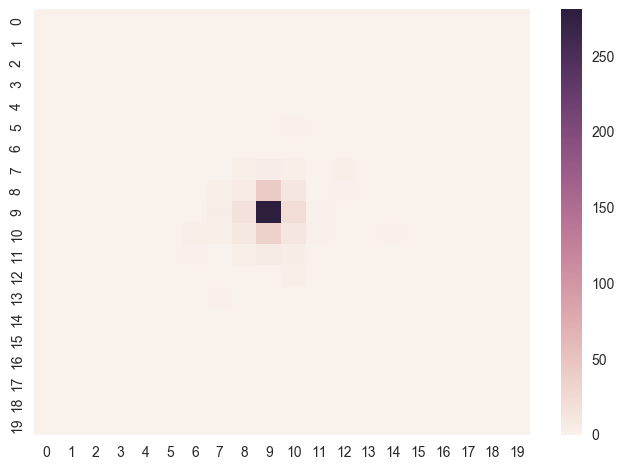

13
----------------------


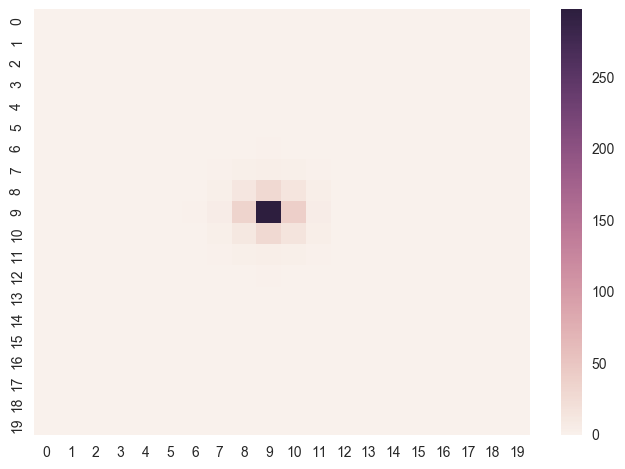

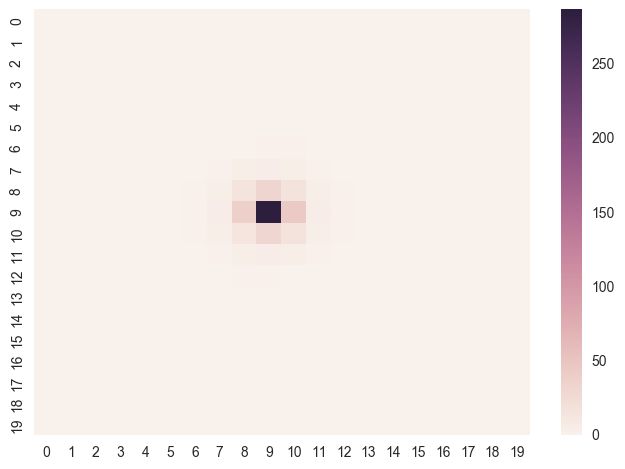

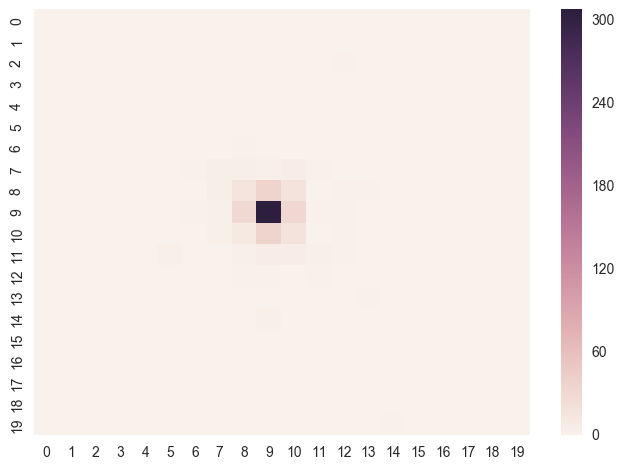

14
----------------------


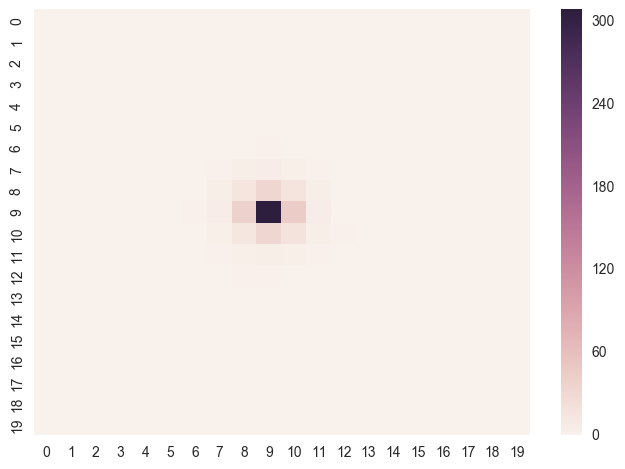

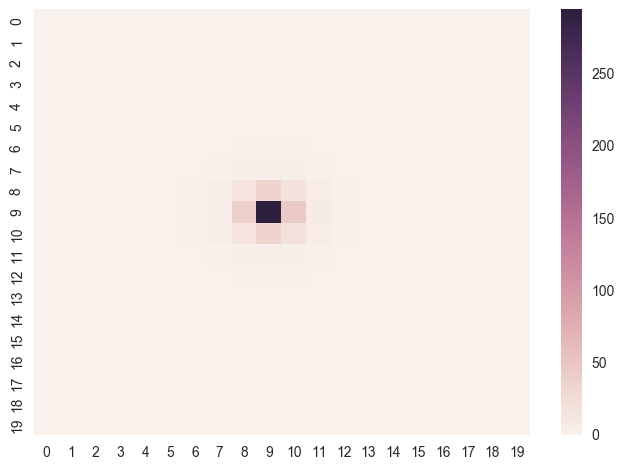

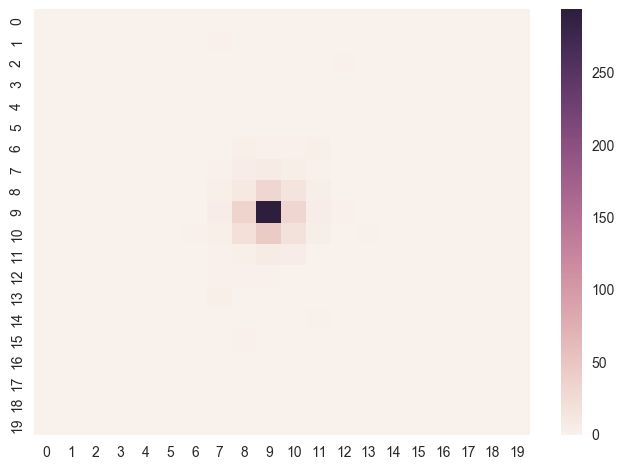

15
----------------------


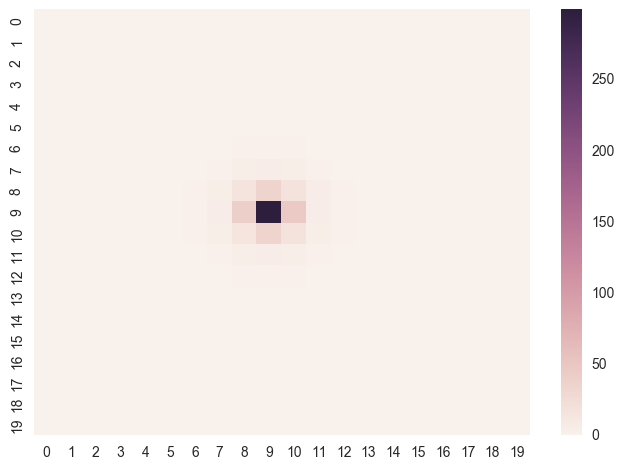

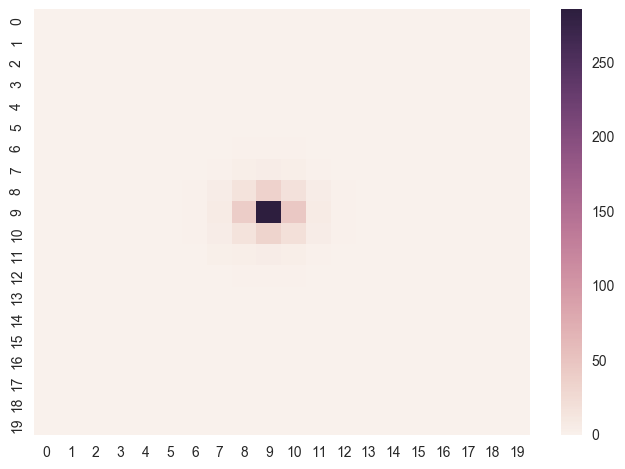

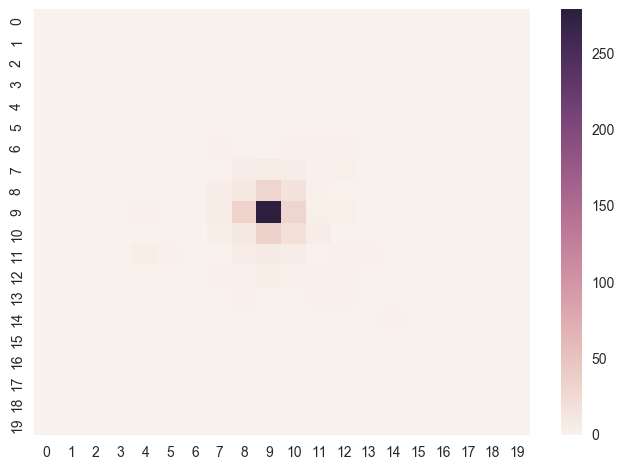

16
----------------------


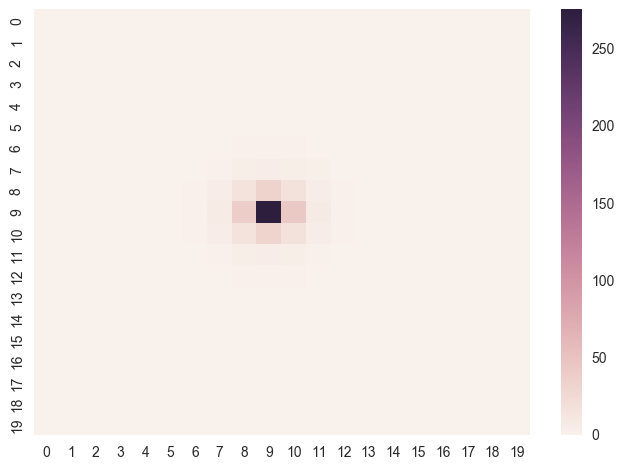

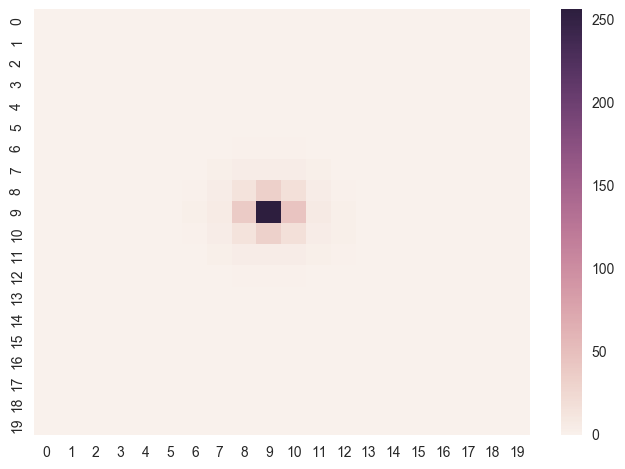

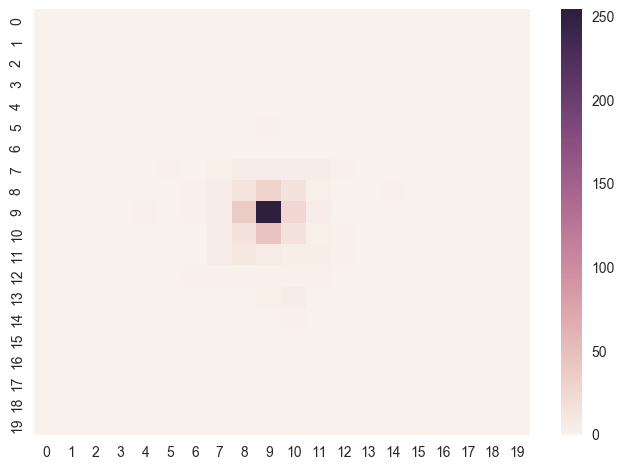

17
----------------------


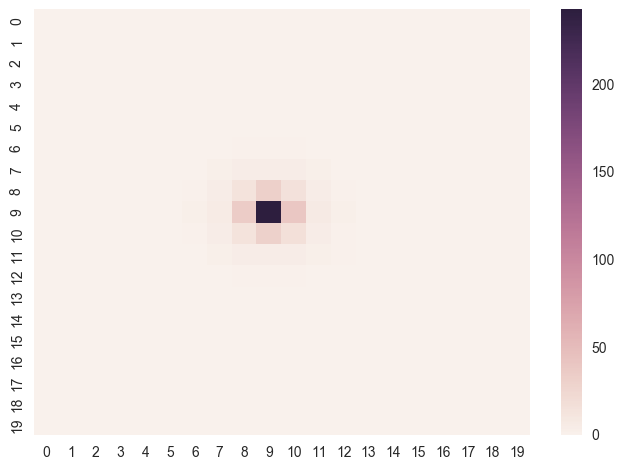

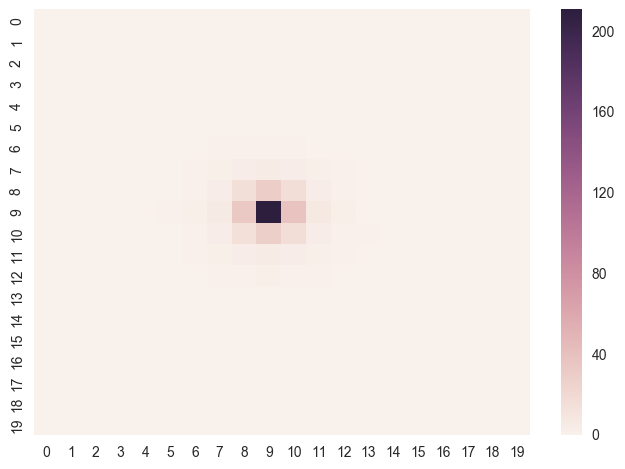

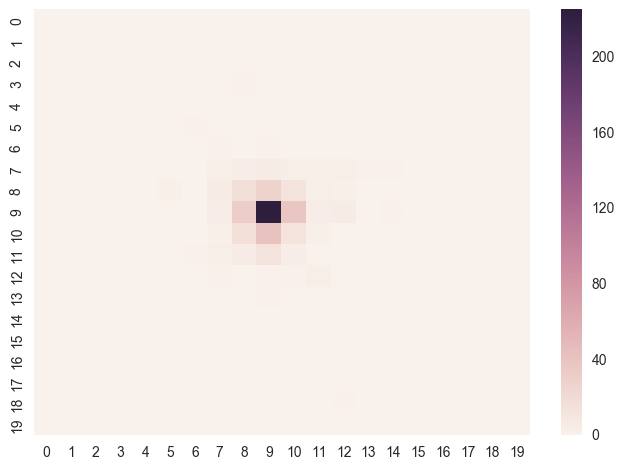

18
----------------------


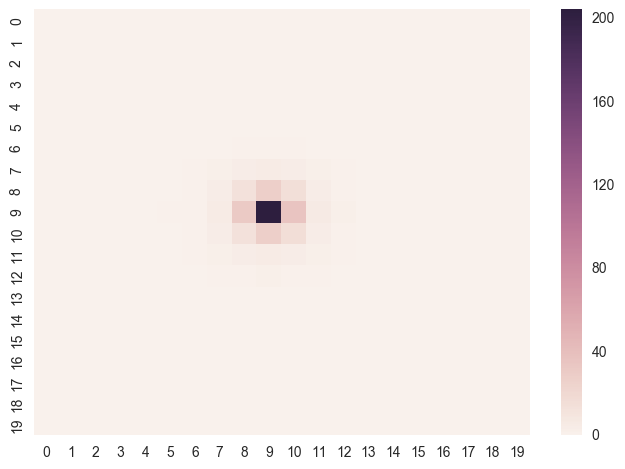

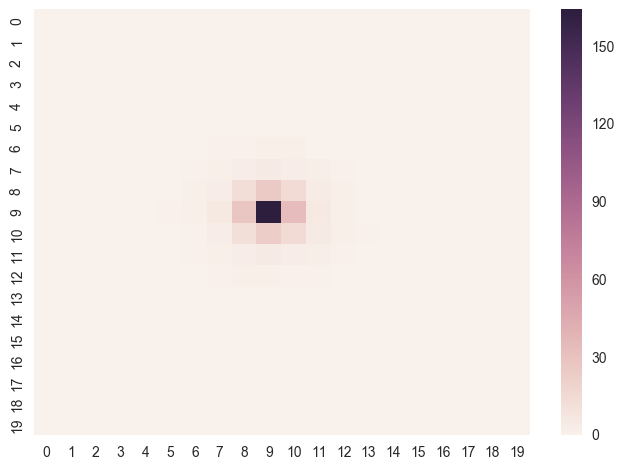

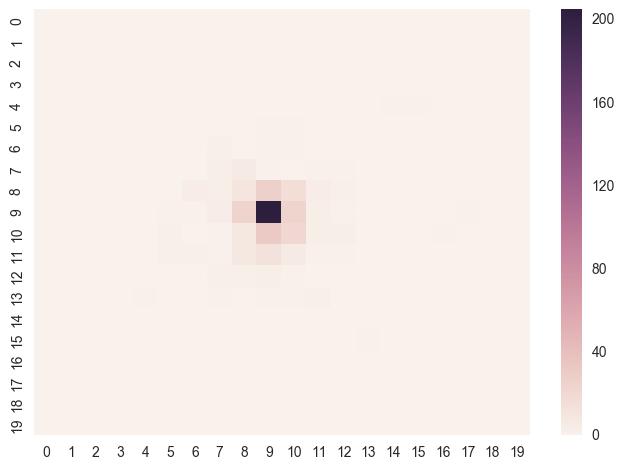

19
----------------------


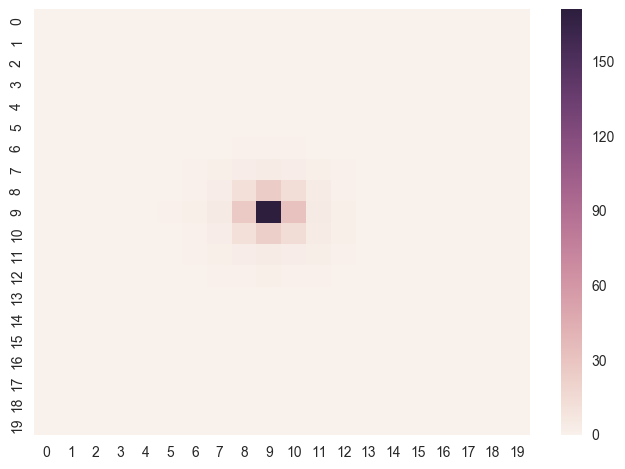

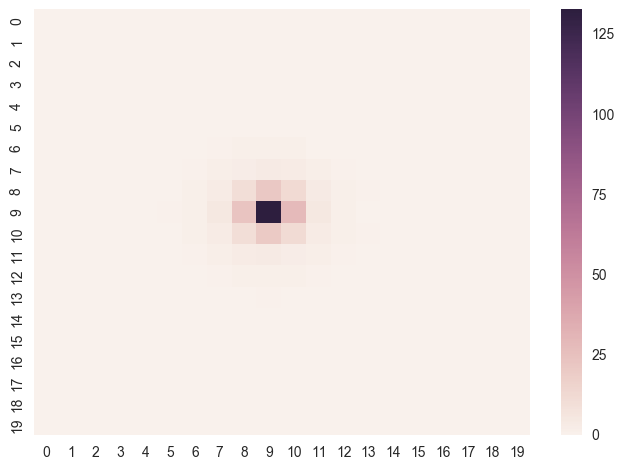

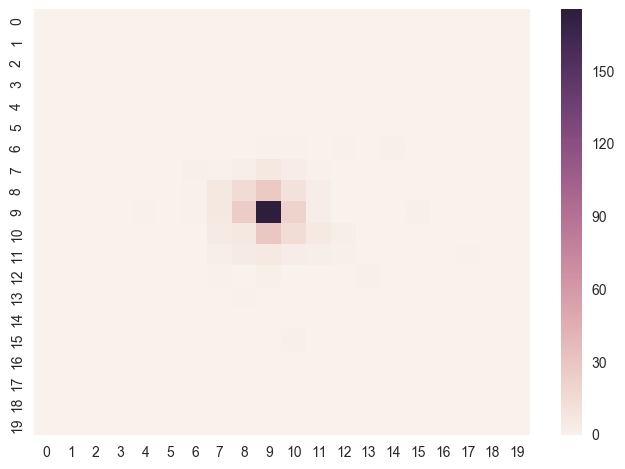

20
----------------------


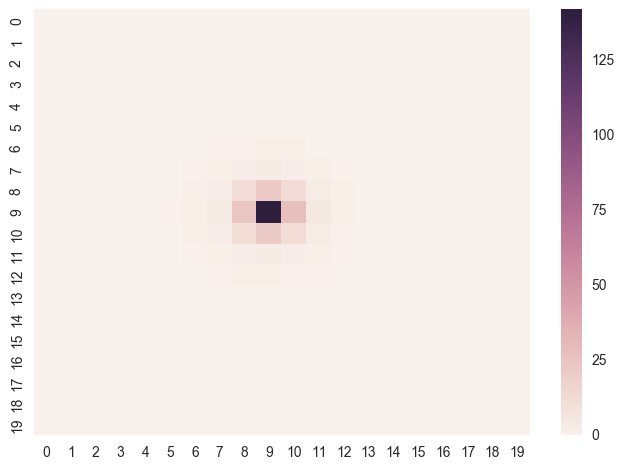

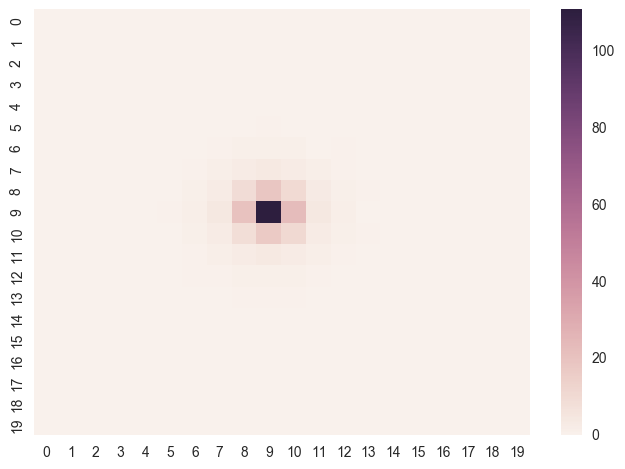

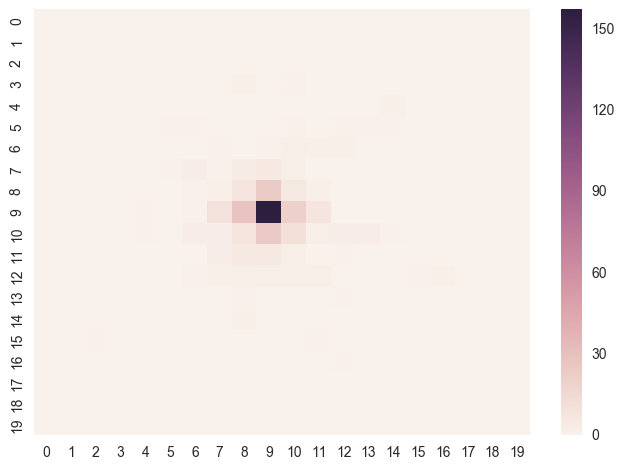

21
----------------------


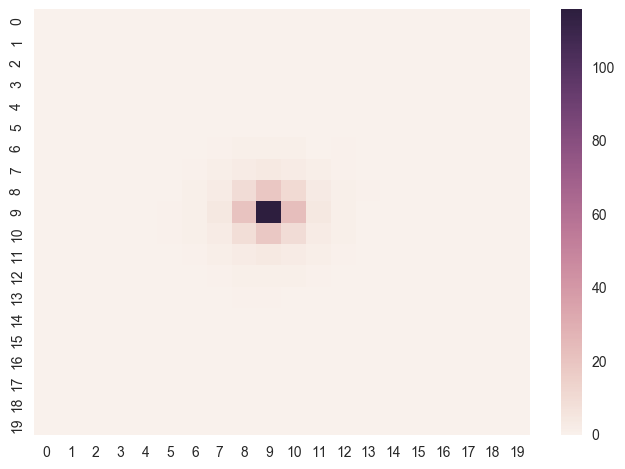

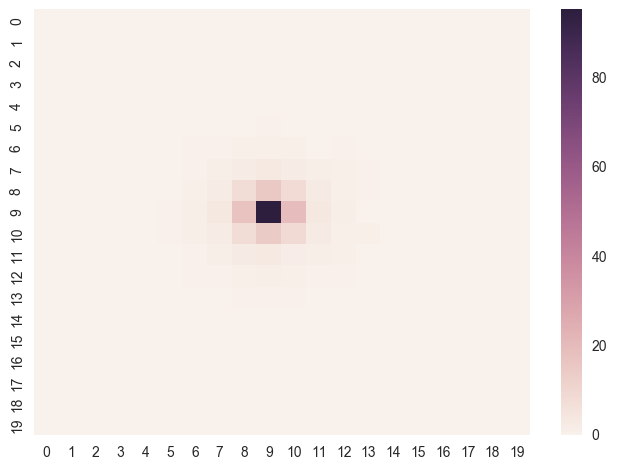

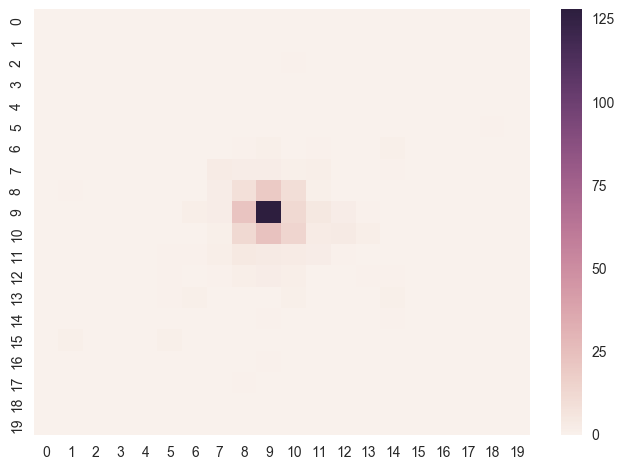

22
----------------------


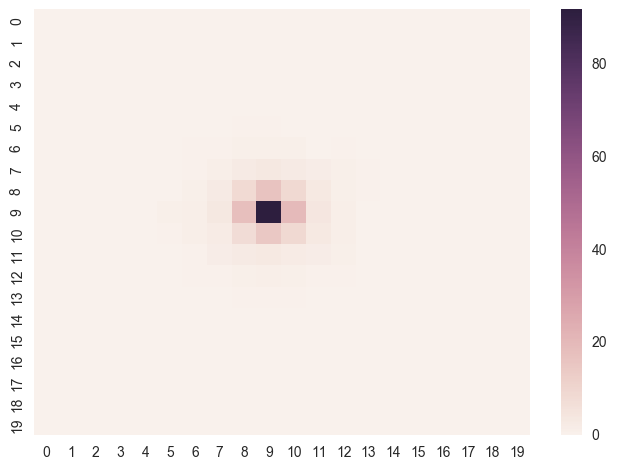

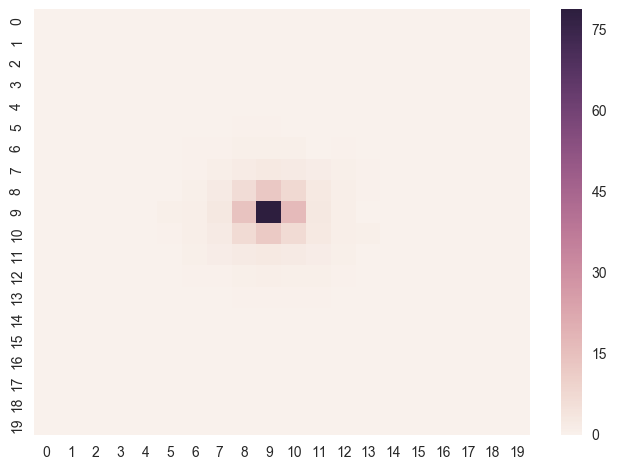

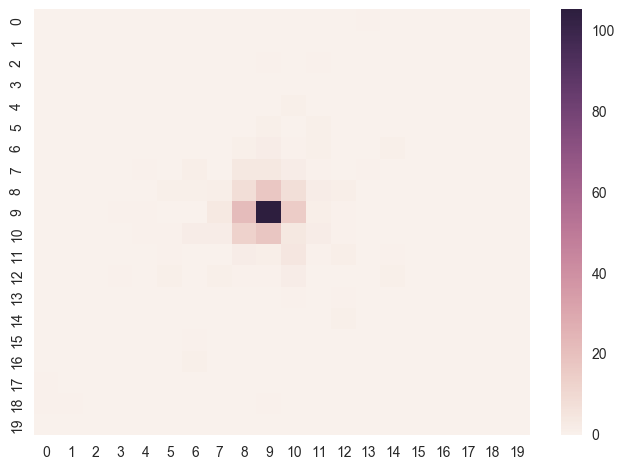

23
----------------------


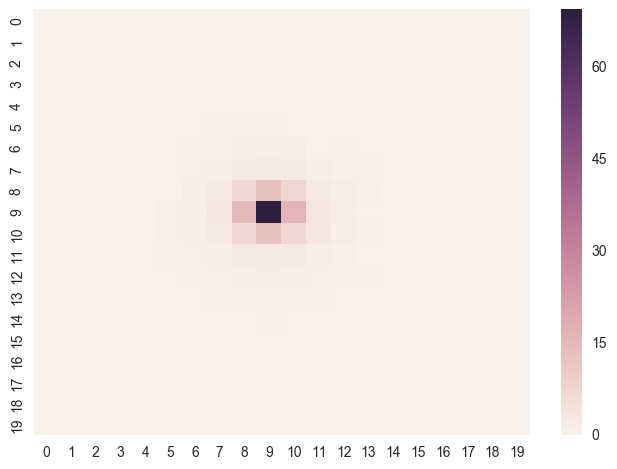

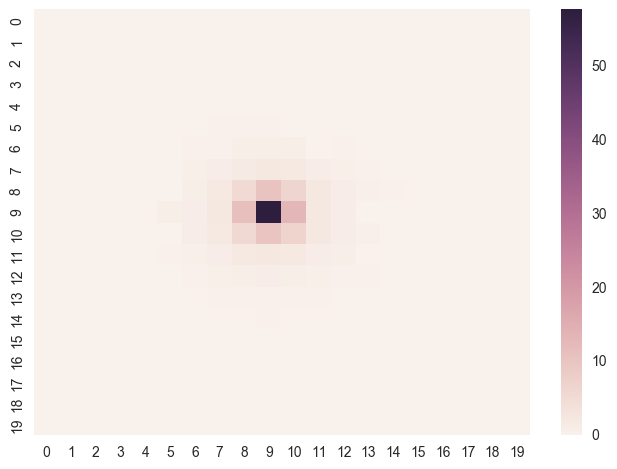

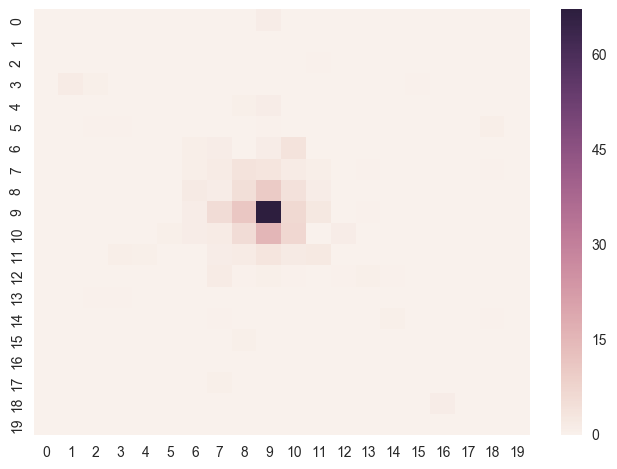

24
----------------------


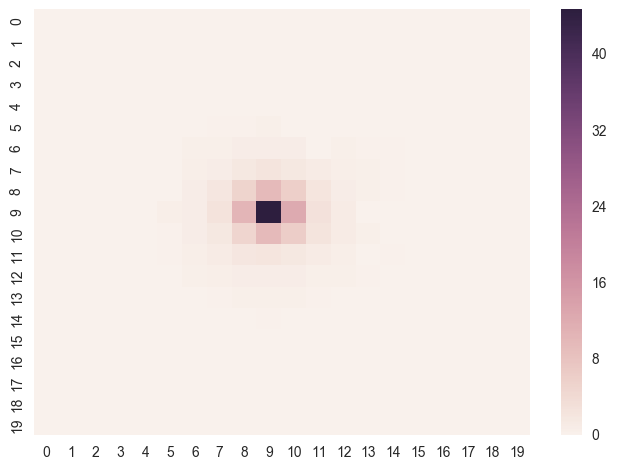

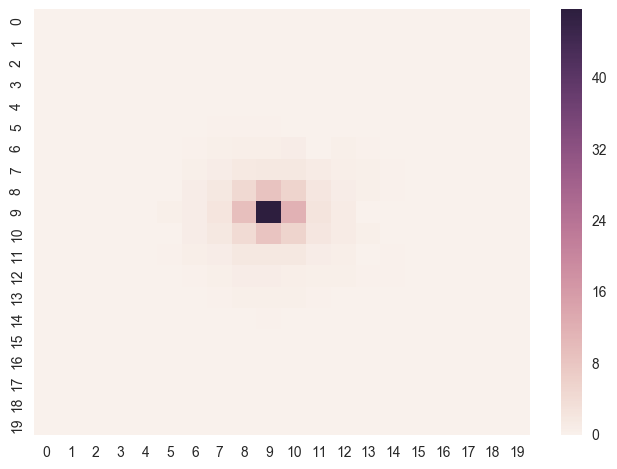

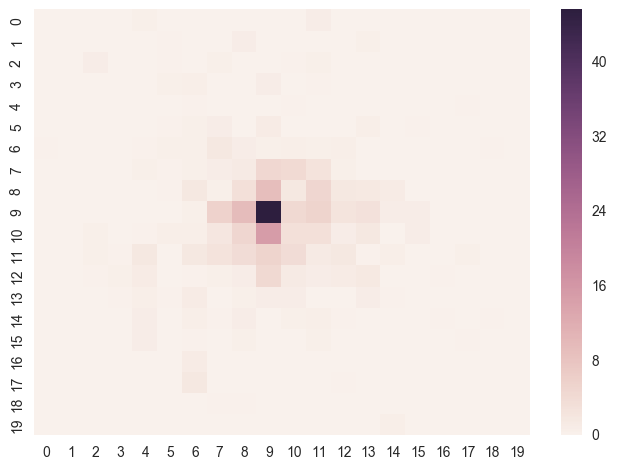

In [20]:
for j in range(pred_full[0].shape[-1]):
    print (j)
    print '----------------------'
    sns.heatmap(pred_full[0,:,:,j])
    plt.show()
    sns.heatmap(gen_full[0,:,:,j])
    plt.show()
    sns.heatmap(true[0,:,:,j])
    plt.show()

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

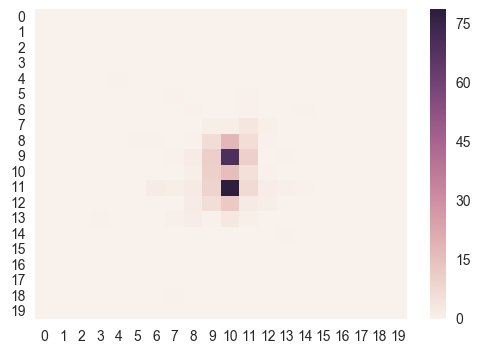

In [37]:
sns.heatmap(np.reshape(x['X_input'][0],(24,20,20))[12])

In [38]:
import viz_tools

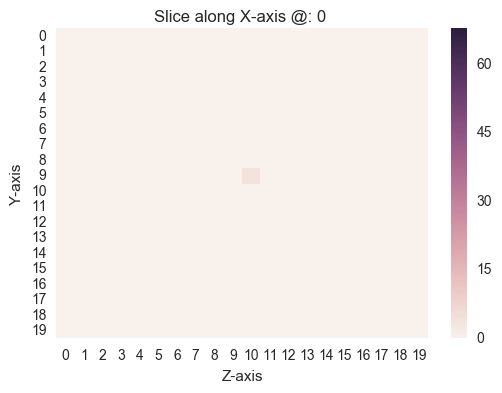

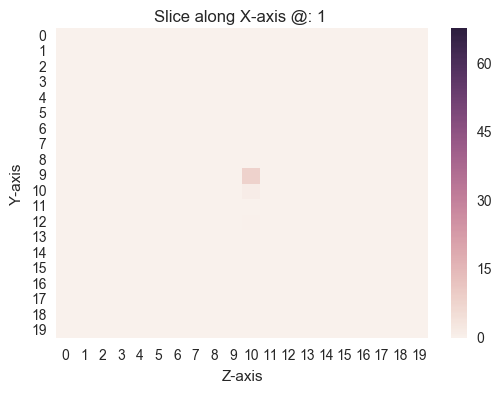

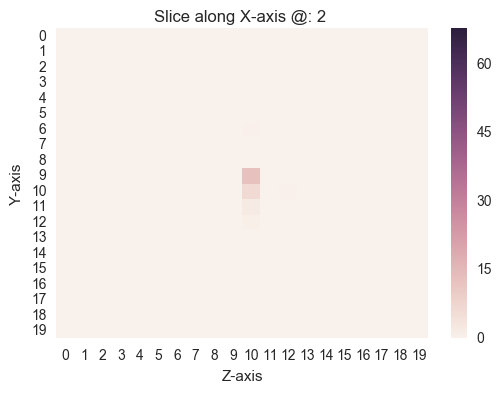

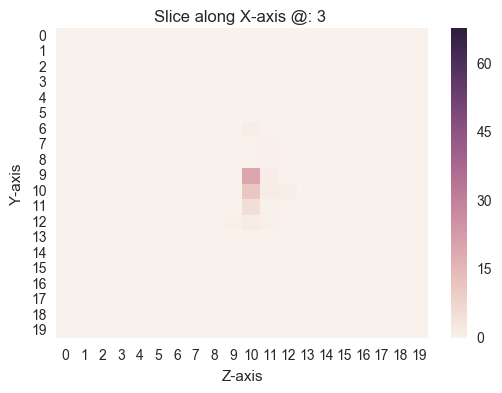

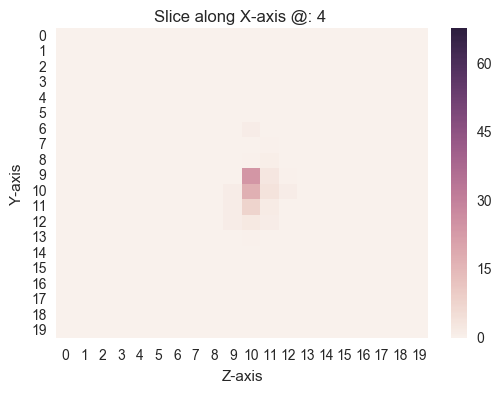

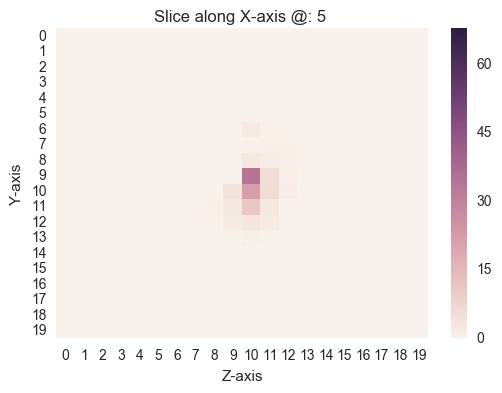

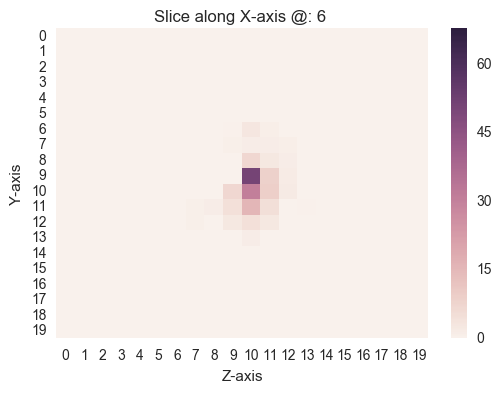

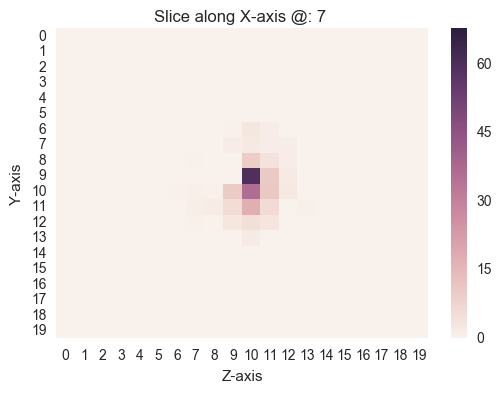

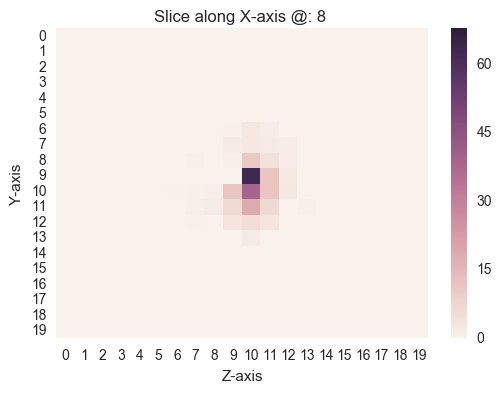

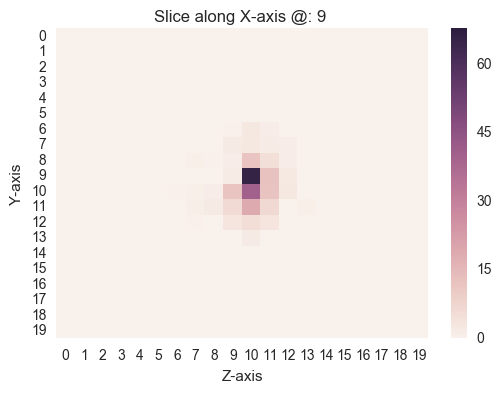

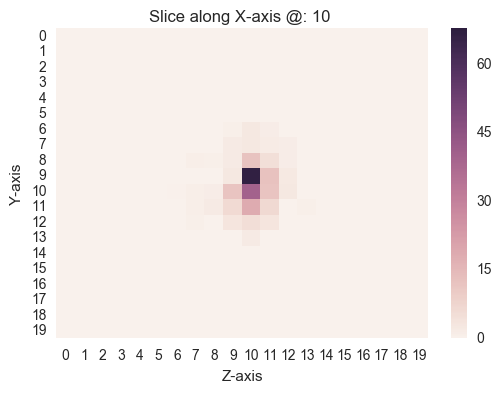

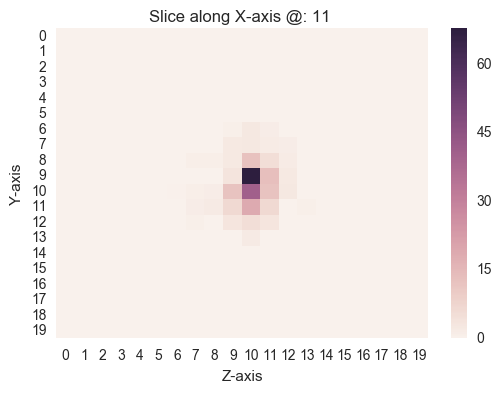

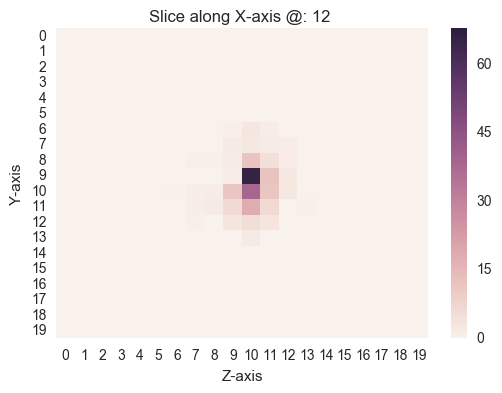

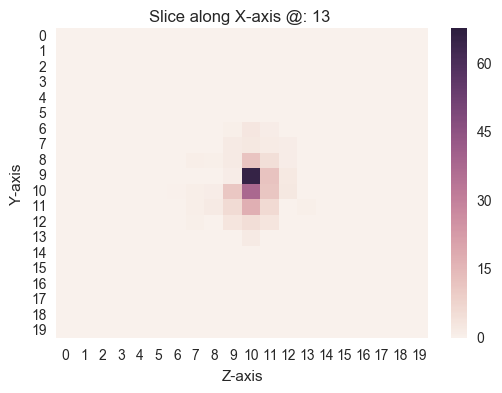

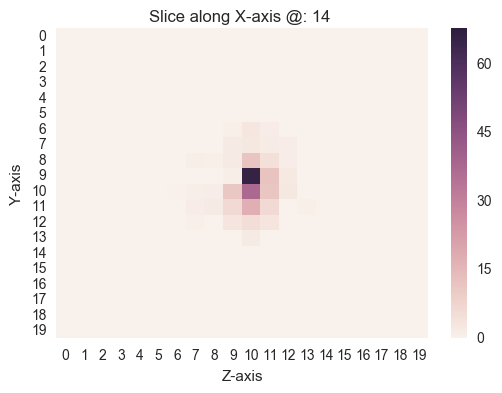

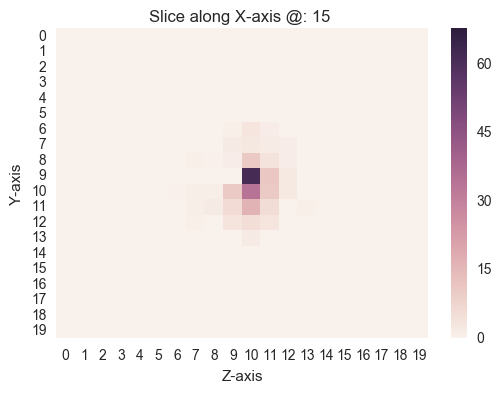

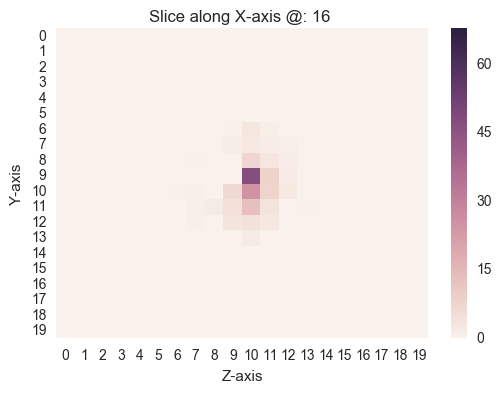

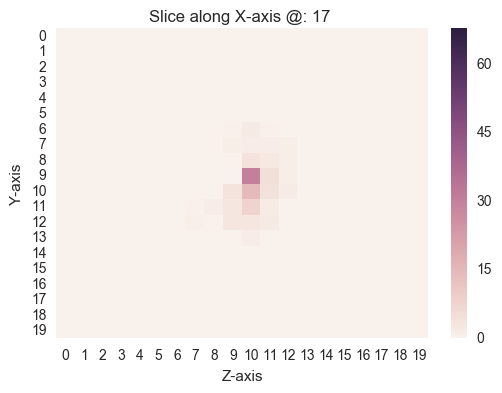

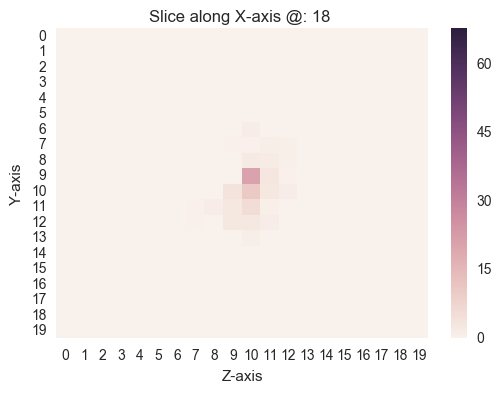

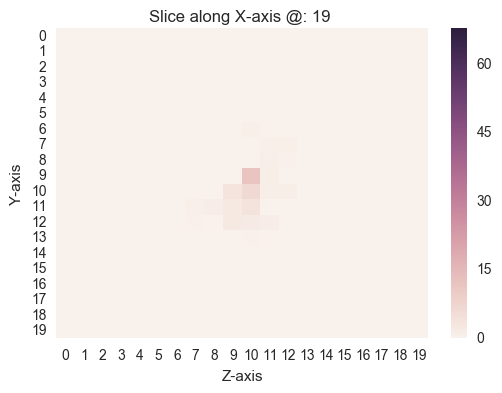

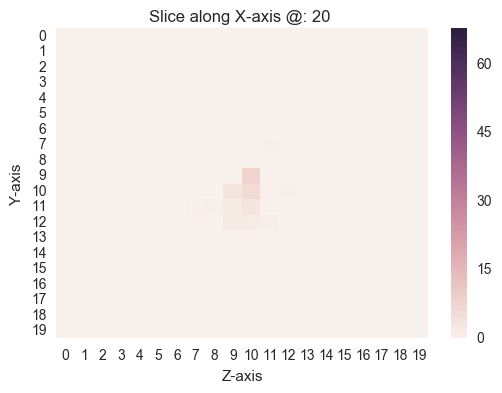

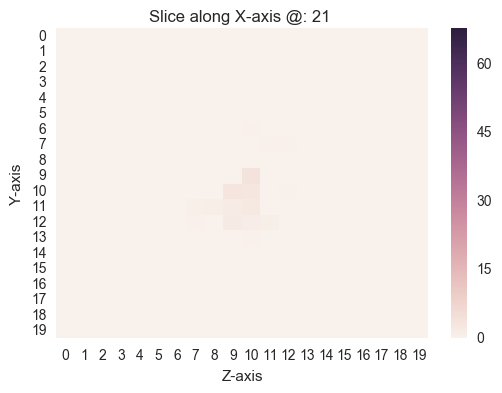

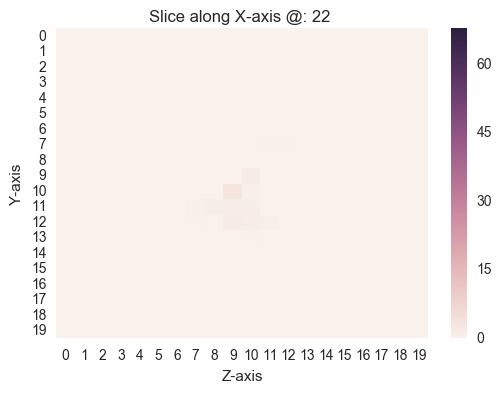

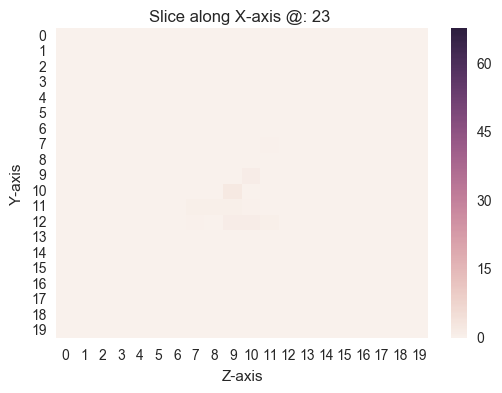

In [46]:
viz_tools.slice_axis_heatmap(p,0)


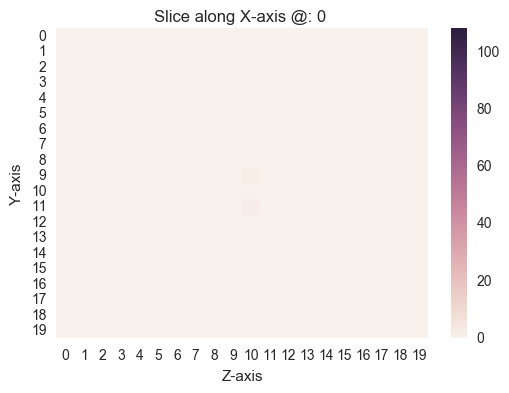

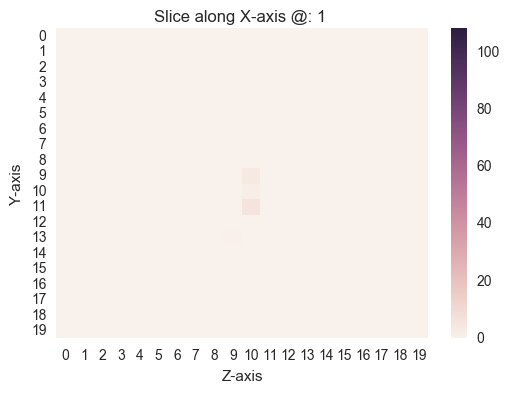

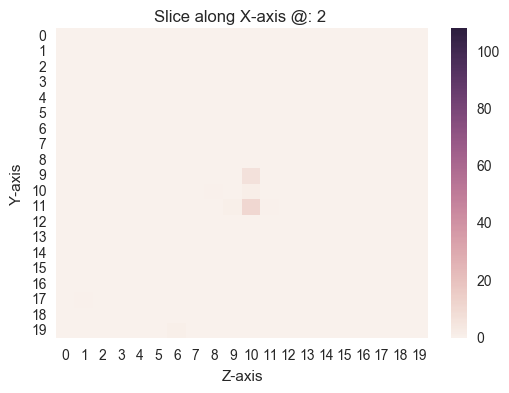

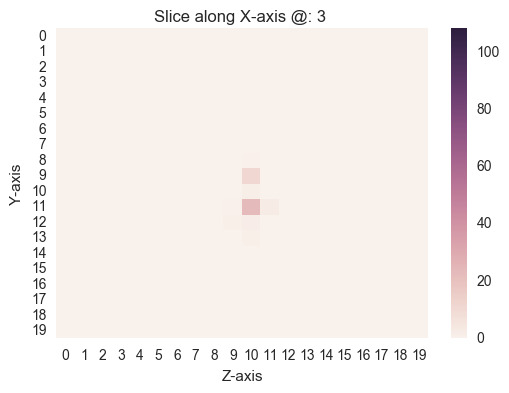

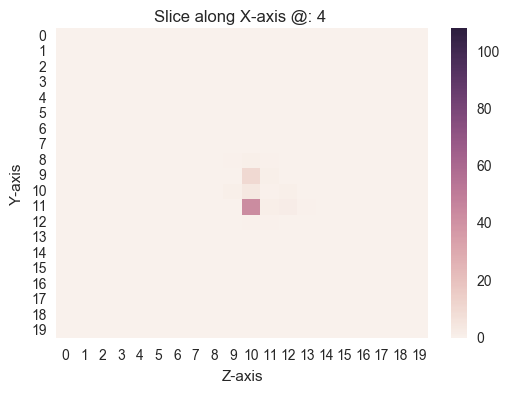

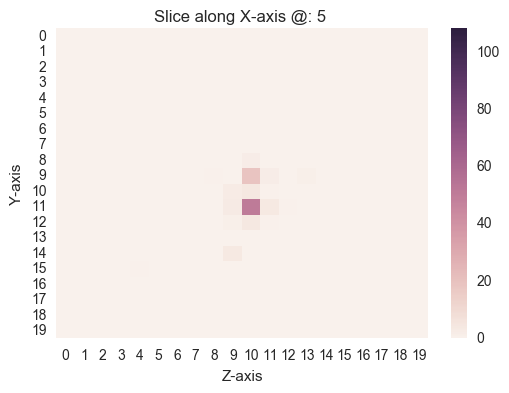

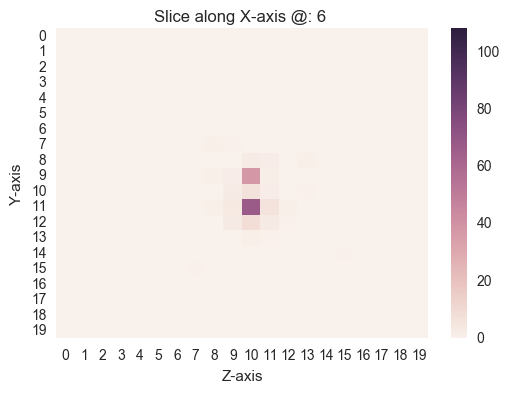

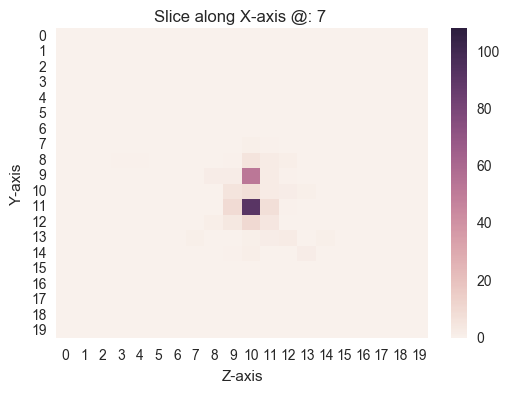

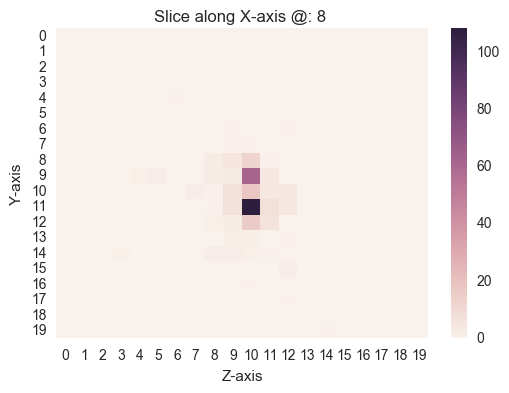

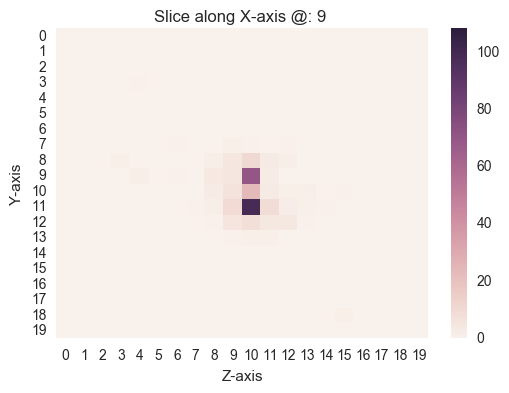

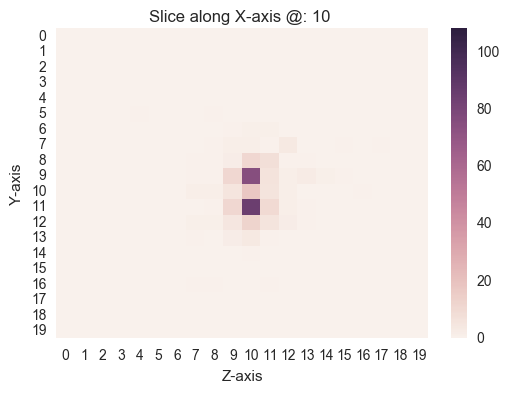

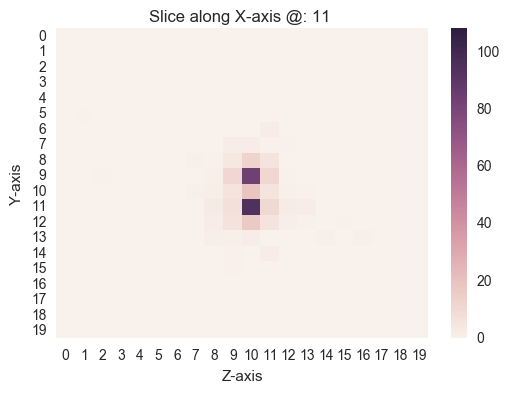

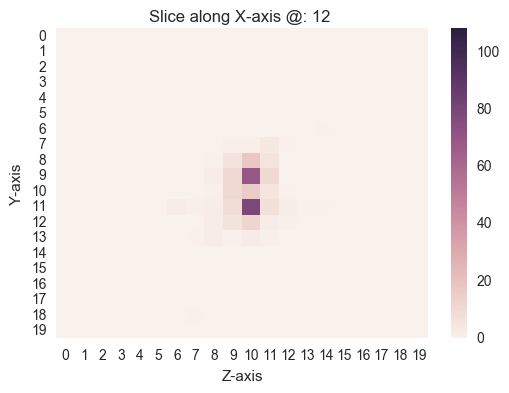

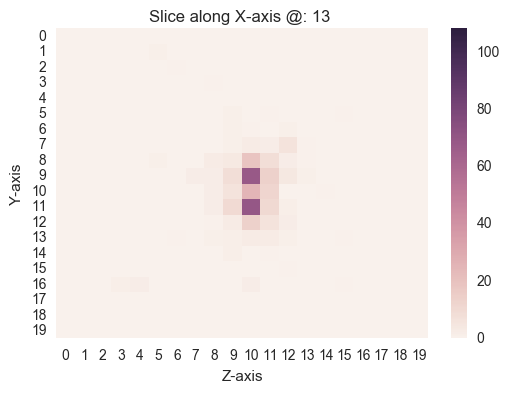

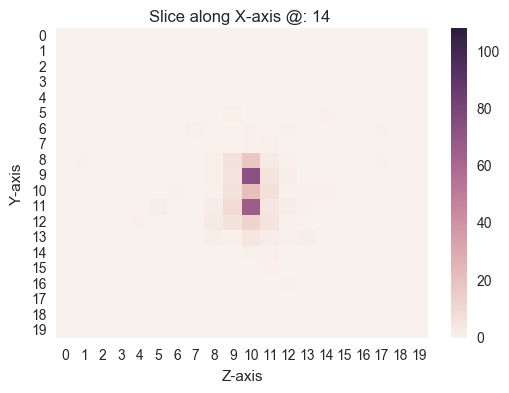

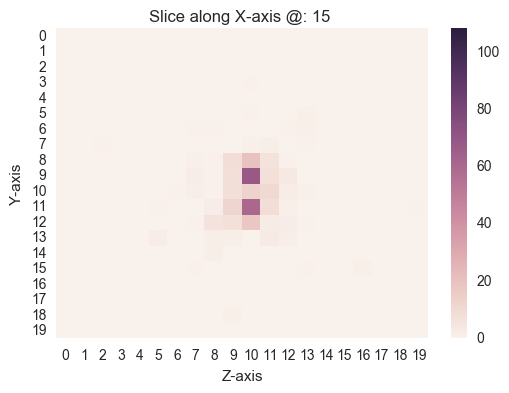

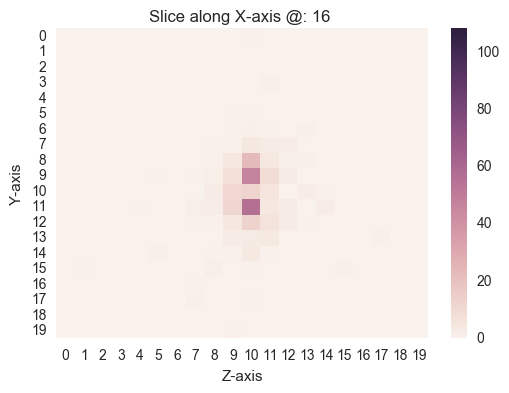

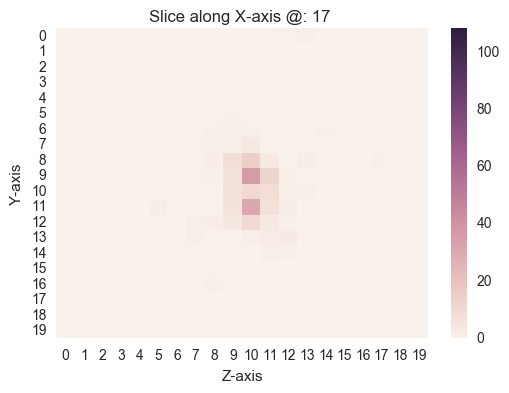

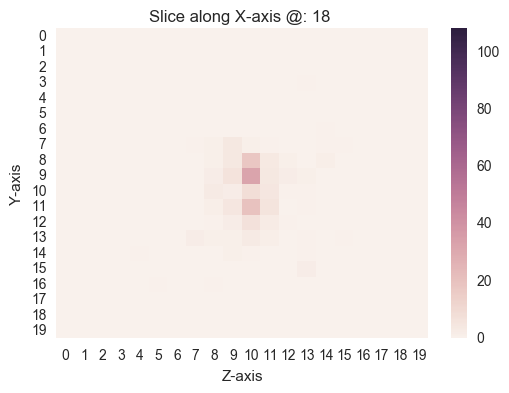

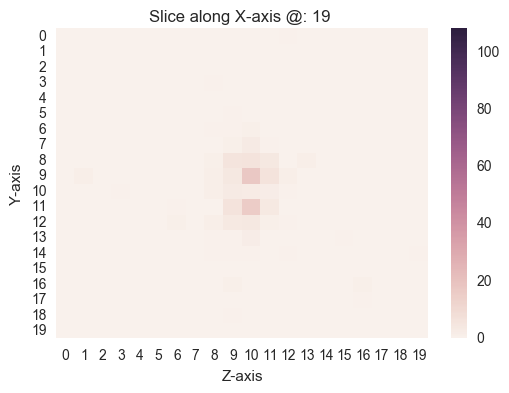

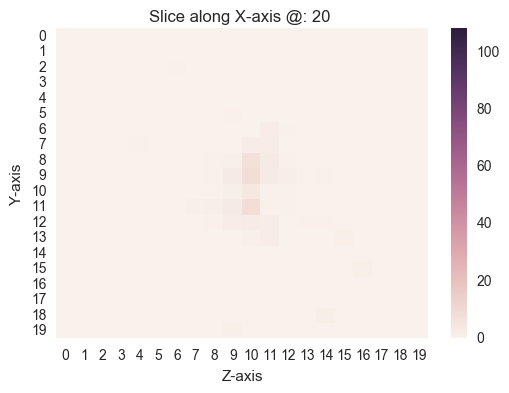

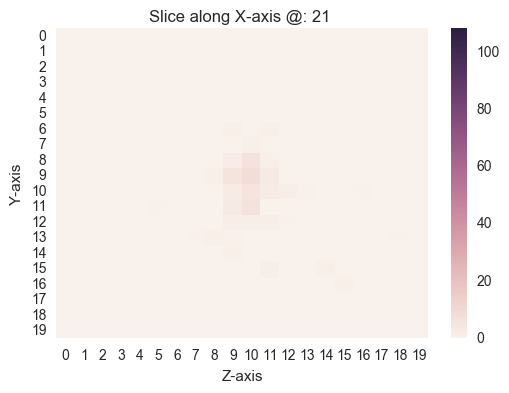

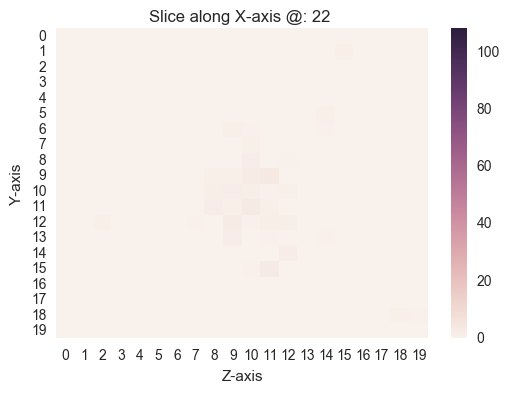

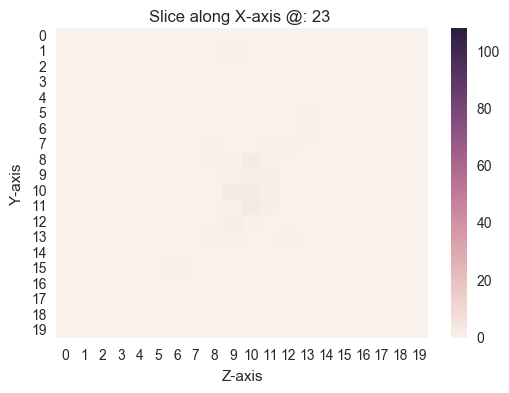

In [47]:
viz_tools.slice_axis_heatmap(np.reshape(x['X_input'][0],(24,20,20)),0)